In [1]:
from data.dataset import XN_PointCloudDataset
import torch.utils.data
import torch
import pytorch_lightning as pl
from model.pointnet2_sem_seg_msg import get_model
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline 

In [2]:
npoints=5000
root='D:/Users/WuTianyi/OneDrive - wutianyidev/NEU/课程/MATH7243 Machine Learning/大作业/Cloud Sample Data'
test_dataset = XN_PointCloudDataset(
    root=root
    ,split='test'
    ,npoints=npoints)
val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    #num_workers=int(opt.workers)
    )
data=next(iter(val_loader))

In [3]:
class Pointnet2_pl(pl.LightningModule):
     def __init__(self):
         super().__init__()
         self.model = get_model(num_classes=2)
            
     def predict(self,x):
        m,n=x.shape
        result=self.model(x.view(1,m,n).transpose(2, 1))[0]
        return torch.argmax(result,dim=-1)[0]
    
     def forward(self,x):
        return self.model(x)

     def training_step(self, batch, batch_idx):
         x, y = batch
         #x=x.transpose(2, 1)
         y_hat, trans_feat = self.model(x.transpose(2, 1))
         y_hat = y_hat.contiguous().view(-1, 2)
         #loss = F.cross_entropy(y_hat, y)
         loss = F.nll_loss(y_hat, y.view(-1),weight =torch.cuda.FloatTensor([2,8]))
         acc = FM.accuracy(torch.exp(y_hat.view(-1,2)), y.view(-1))
         #self.log('training_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
         return loss

     def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, trans_feat = self.model(x.transpose(2, 1))
        y_hat = y_hat.contiguous().view(-1, 2)
        #y_hat = y_hat.view(-1, 1)[:, 0]
        #loss = F.cross_entropy(y_hat, y)
        loss = F.nll_loss(y_hat, y.view(-1),weight =torch.cuda.FloatTensor([2,8]))
        #loss=nn.BCELoss()(y_hat, y.view(-1))
        #print(1-torch.sum(y)/10000)
        predict_sum=torch.sum(torch.argmax(y_hat,dim=-1))
        acc = FM.accuracy(torch.exp(y_hat.view(-1,2)), y.view(-1))
        metrics = {'val_acc': acc, 'val_loss': loss,'val_predict_sum':predict_sum}
        self.log_dict(metrics)
        self.log('val_acc', metrics['val_acc'], on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_predict_sum', metrics['predict_sum'], on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return metrics

     def test_step(self, batch, batch_idx):
        metrics = self.validation_step(batch, batch_idx)
        metrics = {'test_acc': metrics['val_acc'], 'test_loss': metrics['val_loss']}
        #self.log('val_acc', metrics['val_acc'], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(metrics)


     def configure_optimizers(self):
         return torch.optim.Adam(self.model.parameters(), lr=0.0005)

In [8]:
model = Pointnet2_pl.load_from_checkpoint(
    'utils\\lightning_logs\\version_46\\checkpoints\\epoch=87-step=87.ckpt'
    ,hparams_file='utils\\lightning_logs\\version_46\\hparams.yaml')
#print(model)
# prints the learning_rate you used in this checkpoint
model.eval()
y_hat= model.predict(data[0][0])

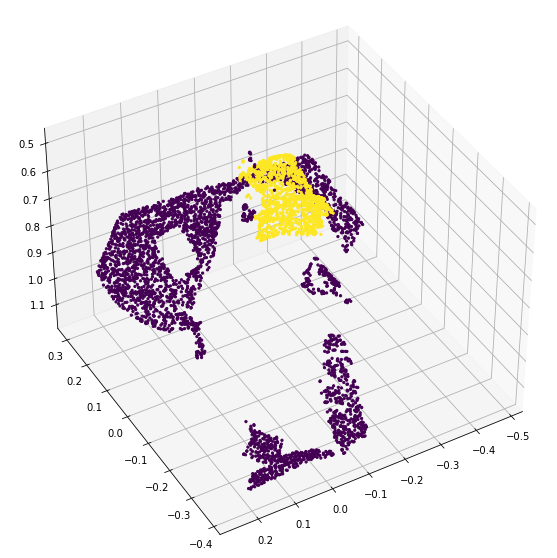

In [6]:
x=data[0][0]
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:,0], x[:,1], x[:,2], c = y_hat, alpha=1, marker='.')
ax.view_init(-140, 120)
plt.show()

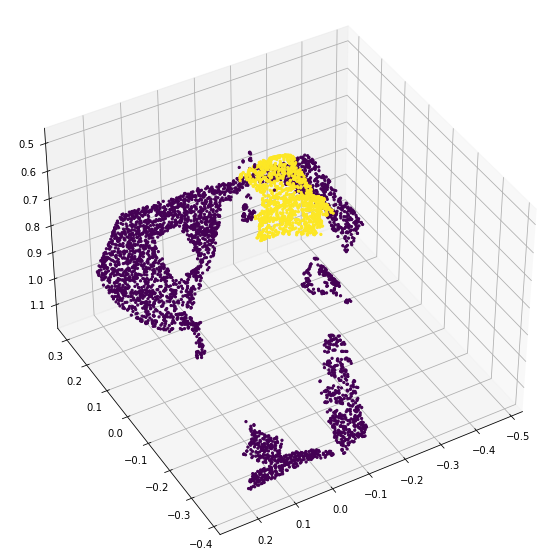

In [7]:
x=data[0][0]
y=data[1][0]
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:,0], x[:,1], x[:,2], c = y, alpha=1, marker='.')
ax.view_init(-140, 120)
plt.show()